# NoiseFlow

> noiseflow


In [1]:
#| default_exp noiseflow

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| hide
from IPython.display import clear_output, DisplayHandle

def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [4]:
 #| export

from fastai.vision.all import nn, torch, np, Path, get_image_files, Image 
from Noise2Model.utils import attributesFromDict
# from Noise2Model.models import DnCNN, UNet
from Noise2Model.utils import gaussian_diag #, batch_PSNR, weights_init_orthogonal #, weights_init_kaiming


## Normalizing Flows


In [5]:
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

### Set up model


1. Define flows


In [6]:
from fastai.data.all import *
from fastai.vision.all import *

In [7]:
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

# K = 32
#torch.manual_seed(0)
# b = torch.tensor([0, 1])
# flows = []
# for i in range(K):
#     s = nf.nets.MLP([2, 4, 4, 2])
#     t = nf.nets.MLP([2, 4, 4, 2])
# if i % 2 == 0:
#     flows += [nf.flows.MaskedAffineFlow(b, t, s)]
# else:
#     flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]

In [8]:
flows

[AffineCouplingBlock(
   (flows): ModuleList(
     (0): Split()
     (1): AffineCoupling(
       (param_map): MLP(
         (net): Sequential(
           (0): Linear(in_features=1, out_features=64, bias=True)
           (1): LeakyReLU(negative_slope=0.0)
           (2): Linear(in_features=64, out_features=64, bias=True)
           (3): LeakyReLU(negative_slope=0.0)
           (4): Linear(in_features=64, out_features=2, bias=True)
         )
       )
     )
     (2): Merge()
   )
 ),
 Permute(),
 AffineCouplingBlock(
   (flows): ModuleList(
     (0): Split()
     (1): AffineCoupling(
       (param_map): MLP(
         (net): Sequential(
           (0): Linear(in_features=1, out_features=64, bias=True)
           (1): LeakyReLU(negative_slope=0.0)
           (2): Linear(in_features=64, out_features=64, bias=True)
           (3): LeakyReLU(negative_slope=0.0)
           (4): Linear(in_features=64, out_features=2, bias=True)
         )
       )
     )
     (2): Merge()
   )
 ),
 Permute(),


2. Set target and base distribution


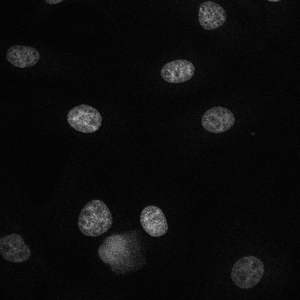

In [9]:
path = Path('../_data/Confocal_BPAE_B/')
path_train_raw = Path(path/"raw")
path_train_gt = Path(path/"gt")
raw_fnames = get_image_files(path_train_raw)
gt_fnames = get_image_files(path_train_gt)
img_gt = Image.open(gt_fnames[0])
img_raw = Image.open(raw_fnames[0])
img_raw.to_thumb(300)


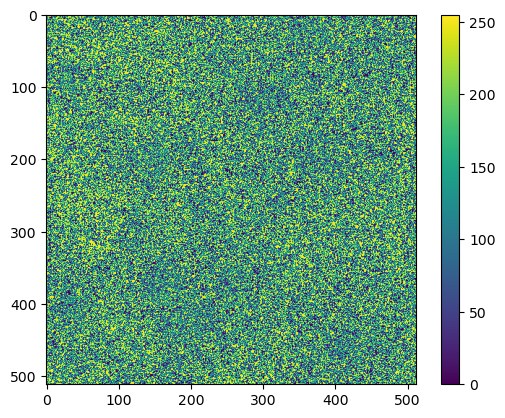

In [10]:
img = np.abs(np.asarray(img_raw) - np.asarray(img_gt)) # / 256.0
plt.imshow(img)
plt.colorbar()

In [40]:
target = nf.distributions.ImagePrior(img)
q0 = nf.distributions.base.DiagGaussian(1)

3. Construct flow model


In [42]:
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=target)

4. Move model on GPU if available


In [43]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

### Plot prior distribution


/tmp/ipykernel_325533/4103372968.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


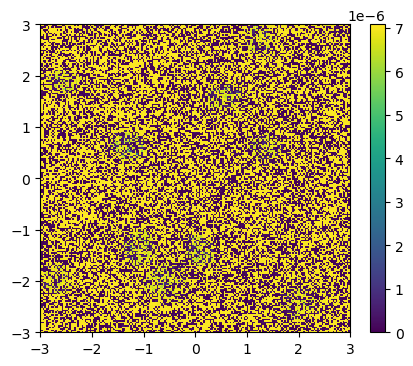

In [44]:
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)

plt.figure(figsize=(5, 4))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.colorbar()
plt.show()


### Plot initial posterior distribution


/tmp/ipykernel_325533/2304229577.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


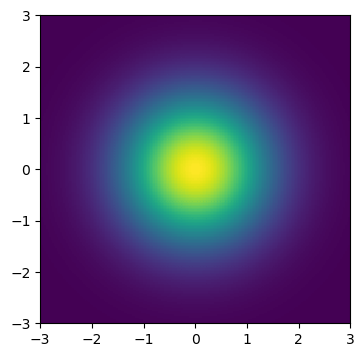

In [15]:
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.show()

## Train model


100%|██████████| 1000/1000 [00:25<00:00, 39.78it/s]


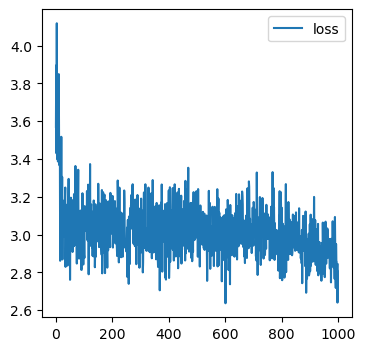

In [16]:
max_iter = 1000
num_samples = 2 * 16
show_iter = 2000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    x = nfm.p.sample(num_samples).double()
    loss = nfm.forward_kld(x)
    loss.backward()
    optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(4, 4))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.show()

plt.figure(figsize=(4, 4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Plot learned distribution


/tmp/ipykernel_325533/2304229577.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy())


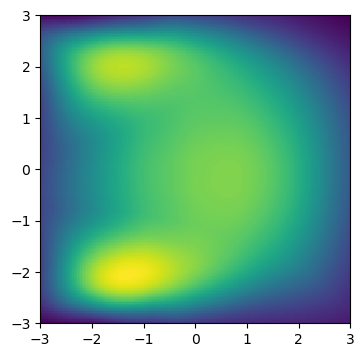

In [17]:
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.show()

# Glow


In [18]:
from torch import randn as torch_randn
from fastai.vision.all import test_eq

In [19]:
# The split mode 'channel' necesitates an even number of channels
channels = 2
hidden_channels = 16

x = torch_randn(1, channels, 16, 16)

tst = nf.flows.AffineCouplingBlock(nf.nets.ConvNet2d([channels//2,hidden_channels,hidden_channels,channels], (3,1,3)))
print(tst)
y, _ = tst(x)
test_eq(y.shape, x.shape)

tst = nf.flows.GlowBlock(channels, hidden_channels, split_mode='channel')
print(tst)
y, _ = tst(x)
test_eq(y.shape, x.shape)

AffineCouplingBlock(
  (flows): ModuleList(
    (0): Split()
    (1): AffineCoupling(
      (param_map): ConvNet2d(
        (net): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.0)
          (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
          (3): LeakyReLU(negative_slope=0.0)
          (4): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): Merge()
  )
)
GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): LeakyReLU(negative_slope=0.0)
              (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
              (3): LeakyReLU(negative_slope=0.0)
              (4): Conv2d(16, 2, kerne

In [20]:
# The 'checkerboard' split mode can be used also with odd numbers of channels
channels = 1
hidden_channels = 16

x = torch_randn(1, channels, 16, 16)

tst = nf.flows.GlowBlock(channels, hidden_channels, split_mode='checkerboard')
print(tst)
y, _ = tst(x)
test_eq(y.shape, x.shape)

GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): LeakyReLU(negative_slope=0.0)
              (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
              (3): LeakyReLU(negative_slope=0.0)
              (4): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
        )
        (2): Merge()
      )
    )
    (1): ActNorm()
  )
)


# Noise Flow


In [21]:
#| export

from normflows.flows import GlowBlock
# from normflows.distributions.base import DiagGaussian
# from Noise2Model.layers.signal_dependant import SignalDependant
# from Noise2Model.layers.gain import Gain
# from Noise2Model.layers.utils import SdnModelScale

In [80]:
#| export
class NoiseFlow(nn.Module):

    def __init__(self, x_shape, arch, param_inits, lu_decomp):
        super(NoiseFlow, self).__init__()
        attributesFromDict(locals( ))
        self.model = nn.ModuleList(self.noise_flow_arch(x_shape))

    def noise_flow_arch(self, x_shape):
        arch_lyrs = self.arch.split('|')  # e.g., unc|sdn|unc|gain|unc
        bijectors = []
        for i, lyr in enumerate(arch_lyrs):
            # is_last_layer = False

            if lyr == 'unc':
                print('|-AffineCoupling')
                bijectors.append(
                    GlowBlock(
                        channels=x_shape[1] * 1,
                        hidden_channels = 16,
                        split_mode='channel' if i == len(arch_lyrs) else 'checkerboard'
                    )
                )
            # elif lyr == 'sdn':
            #     print('|-SignalDependant')
            #     bijectors.append(
            #         SignalDependant(
            #             name='sdn_%d' % i,
            #             scale=SdnModelScale,
            #             param_inits=self.param_inits
            #         )
            #     )
            # elif lyr == 'gain':
            #     print('|-Gain')
            #     bijectors.append(
            #         Gain(name='gain_%d' % i)
            #     )

        return bijectors

    def forward(self, x, **kwargs):
        z = x
        objective = torch.zeros(x.shape[0], dtype=torch.float32, device=x.device)
        for bijector in self.model:
            z, log_abs_det_J_inv = bijector.forward(z, **kwargs)
            objective += log_abs_det_J_inv

            if 'writer' in kwargs.keys():
                kwargs['writer'].add_scalar('model/' + bijector.name, torch.mean(log_abs_det_J_inv), kwargs['step'])
        return z, objective

    def _loss(self, x, **kwargs):
        z, objective = self.forward(x, **kwargs)
        # base measure
        logp, _ = self.prior("prior", x)

        log_z = logp(z)
        objective += log_z

        if 'writer' in kwargs.keys():
            kwargs['writer'].add_scalar('model/log_z', torch.mean(log_z), kwargs['step'])
            kwargs['writer'].add_scalar('model/z', torch.mean(z), kwargs['step'])
        nobj = - objective
        # std. dev. of z
        # mu_z = torch.mean(x, dim=[1, 2, 3])
        var_z = torch.var(x, dim=[1, 2, 3])
        sd_z = torch.mean(torch.sqrt(var_z))

        return nobj, sd_z

    def loss(self, x, **kwargs):
        
        # if 'writer' in kwargs.keys():
        #     batch_average = torch.mean(x, dim=0)
        #     kwargs['writer'].add_histogram('real_noise', batch_average, kwargs['step'])
        #     kwargs['writer'].add_scalar('real_noise_std', torch.std(batch_average), kwargs['step'])

        nll, sd_z = self._loss(x=x, **kwargs)
        nll_dim = torch.mean(nll) / np.prod(x.shape[1:])
        # nll_dim = torch.mean(nll)      # The above line should be uncommented

        return nll_dim, sd_z

    def inverse(self, z, **kwargs):
        x = z
        for bijector in reversed(self.model):
            x = bijector._inverse(x, **kwargs)
        return x
    
    def sample(self, eps_std=None, **kwargs):
        _, sample = self.prior("prior", kwargs['clean'])
        z = sample(eps_std)
        x = self.inverse(z, **kwargs)
        batch_average = torch.mean(x, dim=0)
        if 'writer' in kwargs.keys():
            kwargs['writer'].add_histogram('sample_noise', batch_average, kwargs['step'])
            kwargs['writer'].add_scalar('sample_noise_std', torch.std(batch_average), kwargs['step'])

        return x

    def prior(self, name, x):
        n_z = x.shape[1]
        h = torch.zeros([x.shape[0]] +  [2 * n_z] + list(x.shape[2:4]), device=x.device)
        pz = gaussian_diag(h[:, :n_z, :, :], h[:, n_z:, :, :])

        def logp(z1):
            objective = pz.logp(z1)
            return objective

        def sample(eps_std=None):
            if eps_std is not None:
                z = pz.sample2(pz.eps * torch.reshape(eps_std, [-1, 1, 1, 1]))
            else:
                z = pz.sample
            return z

        return logp, sample

In [81]:
# from torch import randn as torch_randn
# from fastai.vision.all import test_eq

In [84]:
def init_params():
    npcam = 3
    c_i = 1.0
    beta1_i = -5.0 / c_i
    beta2_i = 0.0
    gain_params_i = np.ndarray([5])
    gain_params_i[:] = -5.0 / c_i
    cam_params_i = np.ndarray([npcam, 5])
    cam_params_i[:, :] = 1.0
    return (c_i, beta1_i, beta2_i, gain_params_i, cam_params_i)

x = torch_randn(16,1,64,64)
xdim = len(x.shape)-2

tst = NoiseFlow(x.shape, arch='unc|unc', param_inits=init_params(), lu_decomp=0)
mods = list(tst.children())
print(mods)
# test_eq(tst(x.cuda()).shape, [16, 1, 32, 64, 64])
logp, sample = tst(x)
print(logp.shape)
test_eq(logp.shape, x.shape)
print(sample.shape)

|-AffineCoupling
|-AffineCoupling
[ModuleList(
  (0): GlowBlock(
    (flows): ModuleList(
      (0): AffineCouplingBlock(
        (flows): ModuleList(
          (0): Split()
          (1): AffineCoupling(
            (param_map): ConvNet2d(
              (net): Sequential(
                (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): LeakyReLU(negative_slope=0.0)
                (2): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
                (3): LeakyReLU(negative_slope=0.0)
                (4): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
            )
          )
          (2): Merge()
        )
      )
      (1): ActNorm()
    )
  )
  (1): GlowBlock(
    (flows): ModuleList(
      (0): AffineCouplingBlock(
        (flows): ModuleList(
          (0): Split()
          (1): AffineCoupling(
            (param_map): ConvNet2d(
              (net): Sequential(
                (0): Conv2d(1, 16, kerne

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()